# Data Science på Flashback

Daniel Westerlund \
westerlund@gmail.com \
2021-08-15


* [Introduktion](#Introduktion)
* [Datahämtning](#Datahämtning)
    - [Hur ska data hämtas?](#Hur-ska-data-hämtas?)
    - [Webbskrapning](#Webbskrapning)
* [Analys av data](#Analys-av-data)
    - [Trådanalys](#Trådanalys)
    - [Ordanalys](#Ordanalys)
* [Slutsats](#Slutsats)
* [Källförteckning](#Källförteckning)

# Introduktion

Data Science som karriärspår är något många på kort tid har börjat visa stort intresse för. Har man läst artiklar på nätet om dess historia vet man att termen har funnits i årtionden (testa att googla “when did data science become a thing”), men min uppfattning är att Data Science i dess nutida mening inte tog fart förrän 2010-talet, i takt med att exempelvis smart phones och maskininlärning gjorde entré i världen.

I det här projektet har jag tänkt att utforska antalet trådstartar på Sveriges största webbforum (Flashback) som innehåller vissa nyckelord eller nyckelfraser, till exempel “deep learning”, “big data”, “maskininlärning” eller givetvis “data scientist”. För att filtrera bort så många trådar som möjligt på förhand kommer jag hålla mig till två utvalda kategorier, nämligen *Utbildning och studier* samt *Arbetsliv och arbetsmarknad*. Målet är att visualisera hur “kvantiteten diskussion” kring data science har utvecklats under 2010-talet på webben och på så sätt ge en bild av hur intresset för ämnet har utvecklats IRL. Tesen är att en uppåtlutande trend kommer avslöja sig.

Utöver detta ska jag även undersöka vilka de vanligaste orden i dessa inlägg är, samt analysera om den samlade styrkan i orden pekar på att inläggen är positiva eller negativa.

# Datahämtning

## Hur ska data hämtas?

Det finns för mig ingen tillgång till någon databas eller något API att hämta data från. Istället kommer webbskrapning att utnyttjas. Det innebär att jag kommer använda ett paket som heter `BeautifulSoup4` och ett paket som heter `requests` för att på ett dynamiskt och effektivt sätt hämta önskad data från sajten. För att hantera inhämtad data använder jag också de populära paketen `pandas` och `numpy`. Paketen `re` och `time` används för regular expressions och för att pausa skrapningen mellan varje iteration.


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests, re, time


## Webbskrapning

Låt oss börja med att hämta sex grundläggande variabler, nämligen

* *title*: ämnesrubrik
* *last_response*: datum för senaste svaret
* *responses*: antal svar
* *views*: antal visningar
* *link*: länk till tråden
* *categorie*: kategorin som tråden tillhör.

Följande kodblock skapar en data frame (tabell) med dessa variabler, och kommer kallas på från en for-loop $2\cdot657$ gånger. Vi vill nämligen hämta trådar från så många sidor som möjligt, men från två olika kategorier. Eftersom det i skrivande stund "endast" finns 657 sidor för kategorin *Utbildning och studier* låter vi 647 vara antalet sidor per kategori. 


In [ ]:
# Collect data:

flashback_data = np.empty((0, 6), str)
categories_dict = {'Utbildning och studier': 'https://www.flashback.org/f303', 
                    'Arbetsliv och arbetsmarknad': 'https://www.flashback.org/f105'}

for category, threads_link in categories_dict.items():
    for page_num in range(1, 657):
        try:
            time.sleep(1)
            thread_table_link = threads_link + 'p' + str(page_num)
            html_text = requests.get(thread_table_link, headers={"User-Agent":"Chrome/78.0.3904.87"}).text
            soup = BeautifulSoup(html_text, 'lxml')
            threads = soup.find('table', class_ = 'table table-striped table-threads table-condensed') \
                                .find('tbody').find_all('tr', class_ = None)
            for thread in threads:
                title = thread.find('td', class_='td_title').find('a').text
                last_response = thread.find('td', class_ = 'td_last_post text-right nowrap hidden-xs').find('div').text.strip()[0:10]

                replies_views = thread.find('td', class_ = 'td_replies nowrap text-right hidden-xs').find_all('div')
                responses = ''.join(re.findall('\d+', replies_views[0].text))
                views = ''.join(re.findall('\d+', replies_views[1].text))

                link = 'https://www.flashback.org' + thread.find('td', class_='td_title').find('a')['href']

                # Everything above worked out. Now let's add data to the data_entries array
                row_data = np.array([[title, last_response, responses, views, link, category]])
                data_entries = np.append(arr=data_entries, values=row_data, axis=0)
        except:
            # There might be a few unforeseen errors regarding the HTML scraping. In such cases, we're simply skipping that page
            print('Error at page_num ' + str(page_num) + '. Category: ' + category)
            continue

# Set up a pandas data frame
flashback_df = pd.DataFrame(data=flashback_data, columns=['title', 'last_response', 'responses', 'views', 'link', 'category'])

Innan vi går vidare till att hämta sista bitarna information från sajten måste vi filtrera bort alla trådar som inte är av intresse. Gör vi detta redan nu så undviker vi att hämta resterande data för trådar som inte är intressanta.

`flashback_df` filtreras med hjälp av en ordlista från filen nyckelord.csv, en fil innehållandes 50 stycken ord eller termer som relaterar till Data Science. 

Efter filtreringen innehåller `flashback_df` endast trådar som relaterar till DS. Bra start, men vi vill ha mer information för att kunna utföra analysen. Datum för trådstart hämtas genom att iterera länkarna i `flashback_df` och använda dessa för att komma åt datum för trådstart (`date_of_post`) samt hela det först inlägget (`post`). Dessa variabler samlas i `date_array` respektive `first_post`, som i sin tur läggs in i `flashback_df`.

In [ ]:
import csv

with open('nyckelord.csv', newline='') as f:
    reader = csv.reader(f)
    unflattened_wordlist = list(reader)
    keywords = [word + '|' for sublist in unflattened_wordlist[0:-1] for word in sublist]
    keywords_string = ''.join(keywords) + unflattened_wordlist[-1][0]

# Filter flashback_df for titles containing at least one of the words from keywords.csv
flashback_df = flashback_df[flashback_df['title'].str.contains(keywords_string, case = False)]

# Collect date and first post of each thread
date_array = np.empty(0, dtype=str)
first_post = np.empty(0, dtype=str)
for index, link in enumerate(flashback_df['link']):
    try:
        time.sleep(1)
        html_text = requests.get(link, headers={"User-Agent":"Chrome/78.0.3904.87"}).text
        soup = BeautifulSoup(html_text, 'lxml')
        
        # Collect date
        date_of_post = soup.find('div', class_='post-heading').text.strip()
        date_of_post = ''.join(re.findall("(\d{4}-\d{2}-\d{2})|(Igår)|(Idag)", date_of_post)[0])

        # Collect first post
        post = soup.find('div', class_='post_message').text.strip()

        # Store date and post in their arrays
        date_array = np.append(date_array, date_of_post)
        first_post = np.append(first_post, post)
    except:
        print('Error on index '+ str(index) + '. Link: '+link)
        continue

# Add to data frame
flashback_df['date'] = date_array
flashback_df['first_post'] = first_post

Nu är `flashback_df` nästan klar. För att förberada tabellen så bra som möjligt gäller det att respektive kolumn är av korrekt typ. Funktionen `to_date()` korrigerar de observationer vars datumkolumner antingen har värdet "Idag" eller värdet "Igår". När det är klart har alla datum formatet år-månad-dag, varpå de två datumkolumnerna kan konverteras till typen "datetime". Dessutom konverteras `responses` och `views` till `integer` istället för strängar.

In [3]:
from datetime import date, timedelta

todays_date = date.today().strftime('%Y-%m-%d')
yesterdays_date = date.today() - timedelta(days=1)

def to_date(date_string):
    '''Helper function for coverting strings to correct date on the form Y-m-d'''
    if date_string[0:4] == 'Idag':
        return todays_date
    elif date_string[0:4] == 'Igår':
        return yesterdays_date
    else:
        return date_string


# Correct 'date' and 'last_response' for observations where value = 'Idag ...' or value = 'Igår ...'
flashback_df['last_response'] = flashback_df['last_response'].apply(to_date)
flashback_df['date'] = flashback_df['date'].apply(to_date)

# Convert 'date' and 'last_response' to date type, 'responses' and 'views' to int type
flashback_df['date'] = pd.to_datetime(flashback_df['date'], format='%Y-%m-%d')
flashback_df['last_response'] = pd.to_datetime(flashback_df['last_response'], format='%Y-%m-%d')
flashback_df['responses'] = pd.to_numeric(flashback_df['responses'], downcast='integer')
flashback_df['views'] = pd.to_numeric(flashback_df['views'], downcast='integer')

Den slutgiltiga data frame:en är 2258 rader $\cdot$ 8 kolumner stor och ser ut enligt följande:

In [5]:
# Glimpse of data frame
flashback_df

,title,last_response,responses,views,link,category,date,first_post
0,Kurslitteratur online - Programmering 1 python,2021-08-03,0,285,https://www.flashback.org/t3345728,Utbildning och studier,2021-08-03,Någon som vet var man kan hitta boken: program...
1,Datateknik KTH,2021-08-03,1,551,https://www.flashback.org/t3319003,Utbildning och studier,2021-04-10,Nu är det så att jag har börjat få intresse fö...
2,Varför finns ingen YH programmerings utbildnin...,2021-07-27,1,437,https://www.flashback.org/t3341086,Utbildning och studier,2021-07-14,Känns konstigt \r\nBehöver inte Umeå med omnej...
3,Examenstitlar vid datateknik/-vetenskap?,2021-07-26,6,551,https://www.flashback.org/t3342856,Utbildning och studier,2021-07-22,Jag har blivit alltmer förvirrad av de svenska...
4,Statistik och dataanalys vs tekniskfysik/matem...,2021-07-26,26,1881,https://www.flashback.org/t3339121,Utbildning och studier,2021-07-05,Hej!\r\nJag skulle vilja rådfråga flashback om...
...,...,...,...,...,...,...,...,...
2254,Dataingenjör och Elektroingenjör!,2011-02-01,2,636,https://www.flashback.org/t1442789,Arbetsliv och arbetsmarknad,2011-02-01,"Hej, jag är 20 bast och sitter och tänker på v..."
2255,Arbetsprover för webbutvecklare(som söker jobb),2011-02-01,7,559,https://www.flashback.org/t1439731,Arbetsliv och arbetsmarknad,2011-01-29,Jag söker jobb som programmerare/webbutvecklar...
2256,Vilka Utbildningar krävs för att bli Datatekni...,2011-01-30,11,1203,https://www.flashback.org/t1439587,Arbetsliv och arbetsmarknad,2011-01-29,Hej!\n\r\nSom rubriken lyder;\nVilka Utbildnin...
2257,Systemutvecklare i grannländerna,2011-01-27,1,240,https://www.flashback.org/t1436576,Arbetsliv och arbetsmarknad,2011-01-26,Är idag systemutvecklare på ett mindre företag...


In [3]:
# Temporary code block
import csv
import pandas as pd
import numpy as np


flashback_df = pd.read_csv('flashback_filtered_df.csv', encoding='windows-1252', sep=';')

from datetime import date, timedelta

todays_date = date.today().strftime('%Y-%m-%d')
yesterdays_date = date.today() - timedelta(days=1)

def to_date(date_string):
    '''Helper function for coverting strings to correct date on the form Y-m-d'''
    if date_string[0:4] == 'Idag':
        return todays_date
    elif date_string[0:4] == 'Igår':
        return yesterdays_date
    else:
        return date_string


# Correct 'date' and 'last_response' for observations where value = 'Idag ...' or value = 'Igår ...'
flashback_df['last_response'] = flashback_df['last_response'].apply(to_date)
flashback_df['date'] = flashback_df['date'].apply(to_date)

# Convert 'date' and 'last_response' to date type, 'responses' and 'views' to int type
flashback_df['date'] = pd.to_datetime(flashback_df['date'], format='%Y-%m-%d')
flashback_df['last_response'] = pd.to_datetime(flashback_df['last_response'], format='%Y-%m-%d')
flashback_df['responses'] = pd.to_numeric(flashback_df['responses'], downcast='integer')
flashback_df['views'] = pd.to_numeric(flashback_df['views'], downcast='integer')

# Glimpse of data frame
flashback_df

,title,last_response,responses,views,link,category,date,first_post
0,Kurslitteratur online - Programmering 1 python,2021-08-03,0,285,https://www.flashback.org/t3345728,Utbildning och studier,2021-08-03,Någon som vet var man kan hitta boken: program...
1,Datateknik KTH,2021-08-03,1,551,https://www.flashback.org/t3319003,Utbildning och studier,2021-04-10,Nu är det så att jag har börjat få intresse fö...
2,Varför finns ingen YH programmerings utbildnin...,2021-07-27,1,437,https://www.flashback.org/t3341086,Utbildning och studier,2021-07-14,Känns konstigt \r\nBehöver inte Umeå med omnej...
3,Examenstitlar vid datateknik/-vetenskap?,2021-07-26,6,551,https://www.flashback.org/t3342856,Utbildning och studier,2021-07-22,Jag har blivit alltmer förvirrad av de svenska...
4,Statistik och dataanalys vs tekniskfysik/matem...,2021-07-26,26,1881,https://www.flashback.org/t3339121,Utbildning och studier,2021-07-05,Hej!\r\nJag skulle vilja rådfråga flashback om...
...,...,...,...,...,...,...,...,...
2254,Dataingenjör och Elektroingenjör!,2011-02-01,2,636,https://www.flashback.org/t1442789,Arbetsliv och arbetsmarknad,2011-02-01,"Hej, jag är 20 bast och sitter och tänker på v..."
2255,Arbetsprover för webbutvecklare(som söker jobb),2011-02-01,7,559,https://www.flashback.org/t1439731,Arbetsliv och arbetsmarknad,2011-01-29,Jag söker jobb som programmerare/webbutvecklar...
2256,Vilka Utbildningar krävs för att bli Datatekni...,2011-01-30,11,1203,https://www.flashback.org/t1439587,Arbetsliv och arbetsmarknad,2011-01-29,Hej!\n\r\nSom rubriken lyder;\nVilka Utbildnin...
2257,Systemutvecklare i grannländerna,2011-01-27,1,240,https://www.flashback.org/t1436576,Arbetsliv och arbetsmarknad,2011-01-26,Är idag systemutvecklare på ett mindre företag...


# Analys av data

## Trådanalys

Inledningsvis är det en god idé att skaffa sig en enkel dataöverblick. Till exemepel är andelen trådar från respektive kategori 17% från Arbetsliv och arbetsmarknad, och resterande 83% är från Utbildning och studier.

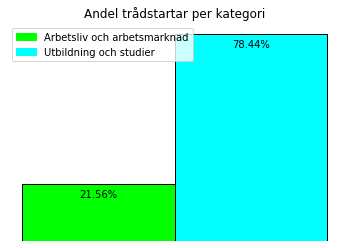

In [4]:
# Diagram: Percentages of threads per categorie 
import matplotlib.pyplot as plt

categories_df = flashback_df.groupby(['category']).size().reset_index(name='count')
num_of_rows = len(flashback_df.index)
categories_df['frequency'] = categories_df['count'] / num_of_rows

plt.bar('category', 'frequency', data=categories_df, width=-1, color=['lime', 'cyan'], edgecolor='black', label='Inline label')
plt.axis('off')
plt.title('Andel trådstartar per kategori')

# Legend
colors = {'Arbetsliv och arbetsmarknad': 'lime', 'Utbildning och studier': 'cyan'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='upper left')

# Show values inside bars
for x, y in enumerate(categories_df['frequency']):
    plt.text(x, y-0.05, "%.2f" % (y*100) + "%", horizontalalignment='center')


Om vi tar alla dessa trådar och dividerar antalet med totala antalet trådar från `flashback_df`, ser vi att andelen endast är """. Det finns trots allt ett stort antal olika yrken och en hel drös med utbildningar i Sverige, så även om datavetenskap och andra relaterande ämnen som statistik- eller teknik är populära, tar de ändå en förhållandevis liten plats i jämförelse med allt annat samlat. Dessutom finns givetvis chansen (eller risken, från denna rapports perspektiv) att vissa enskilda trådar äter upp ett stort antal inlägg som egentligen hade kunnat varit egna trådar.

Låt oss då se hur de ämnesrelaterade trådarna vi hittar i `filtered_df` har utvecklats under 2000-talet såhär långt. Som vi ser i följande kodstycke har jag filtrerat bort år 2021 eftersom det precis har startat. Det vore ju orättvist mot 2021 att inte ge det samma förutsättningar som de andra åren! 

In [ ]:
# Diagram: Number of threads related to DS per year since 2003

Åren 2003 till 2007 har nästan noll till antalet. Det dröjer till 2008-2010 innan antalet börjar stiga på riktigt. Här passar det bra att tipsa den intresserade om en artikel från Forbes som heter "A Very Short History of Data Science" (länk i källförteckning). Artikeln är från 2013, men ger en informativ beskrivning av hur Data Science historia såg ut fram till den tidpunkten. I slutet av artikeln framgår det bland annat att tillväxten av analytiker- och Data Science-jobb i princip går spikrakt upp 2009-2010, vilket stämmer väl överens med vad figur 2 ovan antyder om intresset för ämnet. 

Efter 2012 ser vi däremot en oväntad nedgång i antalet inlägg. En tanke är att detta kan ha att göra med vad jag nämnde tidigare, nämligen att nya inlägg postas i befintliga trådar istället för att skapa nya trådar. Dessa kan alltså tänkas ta upp en hel del inlägg som egentligen skulle kunna ha varit starten på nya trådar.

När vi ändå är inne på det spåret kan vi också kolla på det datum då det senaste inlägget publicerades i de trådar med flest svar. Vi försöker alltså svara på frågan "Är de största trådarna fortfarande aktiva?". De 10 största trådarna från respektive kategori ser vi i de två tabellerna nedan.

In [ ]:
# Table: Top 10 threads with the most answers from Utbildning och studier

# Table: Top 10 threads with the most answers from Arbetsliv och arbetsmarknad

"Master i statisik" innehåller 162 svar och därför skulle man kunna tänka sig denna innehåller många inlägg som annars kunde varit egna trådar. Denna tråds senaste inlägg publicerades dock 2010, så i det här fallet fallerade resonemanget tyvärr. I tabell 2 ser det bättre ut. Den tredje största tråden från *Arbetsmarknad och arbetsliv* heter nämligen "Data scientist", spot on med andra ord! Detta är en hyggligt stor tråd från 2017 med 126 svar, där det senaste svaret publicerades för två veckor sedan. Med andra ord tråd som fortfarande är aktiv. Även den fjärde största tråden är intressant, eftersom Business Intelligence är nära kopplat till Data Science. Denna tråd ser ut att vara ungefär lika aktiv som "Data scientist".

För att få en överblick över hur många relaterade trådar som verkar ha dött ut kollar vi även antalet trådar vars senaste inlägg publicerades samma år. 

In [ ]:
# Diagram: Number of threads for which the latest answer were published the same year

Inte helt oväntat är det många trådar från 2011-2015 som inte är aktiva längre. Värt att notera är dock att det under perioden 2017-2020 är flera trådar som är aktiva än vad publicerats helt nya trådar. Det är givets vad man också kunde förväntat sig ju närmare nutid man tittar. En tråd som publicerades 2020 kan ju inte ha sitt senaste svar från 2019, till exempel. 

## Ordanalys

Vi ska nu se om vi kan ta reda på styrkan i inläggen. Med styrka menas alltså ordens "sentiment", som på engelska betyder ungefär "känsla" eller "stämning". För att lyckas med detta krävs en tabell med ett stort antal vanliga svenska ord tillsammans med respektive ords styrka. Ett sådant sentimentlexikon finns tillhandahållen på GitHub (se kod/källhänvisnning), fri att använda för vem som helst.

Innan vi tittar på inläggens styrka så undersöker vi vilka de vanligaste orden är. Ord som "jag", "hej" eller liknande kallas för stoppord. Dessa är förstås ointressanta. Istället skapar vi ett så kallat word cloud där dessa ord är bortfiltrerade. För detta ändamål används ytteliggare två paket; `wordcloud2` för skapandet av ordmolnet och `RColorBrewer` för tillhörande färgschema.

In [ ]:
# Word cloud

Att visualisera de vanligaste orden på det här sättet är dels fint att titta på, men det är också ett effektivt sätt att bilda en uppfattning om de vanligaste orden. Matematik och programmering toppar listan.

Vidare till inläggens styrka. För att lyckas med detta skapar jag en ny data frame, `threads_sentiment_df`. Utöver de redan kända variablerna ID, title, date och categorie, innehåller denna tabell även

* *word_matches*: antal ord från trådstartarens första inlägg som matchats med något av orden i `sentiments_df`
* *post_strength*: den beräknade styrkan i respektive inlägg
* *pos_proportion* och *neg_proportion*: andelen matchade ord som är markerade som positiva respektive negativa.

Efter att ha sammanfogat de önskade variablerna (kolumnerna) från `filtered_df` med de önskade variablerna från `sentiments_df` passar jag även på att filtrera bort alla trådar som har färre än 20 stycken ordmatchningar. Anledningen till detta är att det finns trådar vars första inlägg är väldigt korta och kanske bara har ett fåtal ordmatchningar. Om dessa ord råkar vara markerade som negativa och med negativ styrka kommer hela inlägget att framstå som väldigt negativa, när deras enda brott kanske egentligen var att inlägget var kort. Kvar har vi en tabell med 126 trådar och följande struktur:

In [ ]:
# Glimpse of sentiment data frame

Med hjälp av ett spridningsdiagram blir det enklare att förstå vår data. Jag låter en grön linje gå längs noll, som representerar en neutral styrkenivå. 

In [ ]:
# Scatter diagram: Thread starters inital posts' word strength

Spridningen ser ganska jämn ut, möjligen något positivt lutande. Andelen positiva inlägg är `r prop_pos_posts*100`%. Däremot är den genomsnittliga styrkan i inläggen endast `r mean_strength`, dvs ganska neutral.

En sak som vore intressant i det här läget är att titta på de mest positiva och de mest negativa inläggen för att se om tabellen talar sanning. Följande inlägg har högst/lägst styrka.

In [ ]:
# Table: Threads with highest strength

# Table: Threads with lowest strength

Öppningsinlägget från tråden "KTH eller Chalmers? Stockholmare som ska plugga datateknik." lyder såhär:

In [ ]:
# Inital post from the thread with highest strength

Personen bakom inlägget använder ord som "bästa", "bättre", "passionerad", "lyckas" och "uppskattas" vilket antagligen lagt till positiv styrka från sentimenttabellen. Dock förekommer även negativa ord som "less", "rädd", "larm" och "jättefarligt", vilket såklart drar ner styrkan. 

Vi tittar också på öppningsinlägget från tråden "Stöd angående val av studier [Datavetenskap mm]".

In [ ]:
# Inital post from the thread with lowest strength

Ja, ett inlägg som öppnar med "Jag har extrem ångest" är såklart illavarslande vad gäller den positiva styrkan. Sedan fortsätter inlägget med ord som till exempel "ifrågasätter", "misstag", "mesig", "dum" och "osäker". Reslutatet? Högsta placering på listan med de mest negativa inläggen!

# Slutsats

Vad gäller tesen om att antalet trådstartar skulle befinna sig i en slags uppåtlutande kurva måste jag tyvärr konstatera att inhämtad data inte styrker det påståendet. Snarare tvärtom faktiskt! Delförklaringen till detta kan vara att nya inlägg postas i befintliga trådar, men det kan likväl vara så att antalet aktiva användare på forumet har gått ned. 

Om både sentimentlistan och inläggen hade varit längre skulle antagligen tabellerna vara säkrare. Nu fanns det en stor begränsning i antal ord eftersom sentimentlistan inte täcker in i närheten av så många ord som man hade önskat (den består av 2067 ord). Dessutom innehåller inte inläggen så mycket text. Jag anser att sentimenttabellen tycks fungera någorlunda bra eftersom min känsla efter att ha läst inläggen korresponderar med inläggens påstådda styrka från tabellerna.

# Källförteckning

Press, G. 2013. *A Very Short History Of Data Science*. www.forbes.com. 2013-05-28. Tillgänglig: https://www.forbes.com/sites/gilpress/2013/05/28/a-very-short-history-of-data-science/?sh=21ae6fbb55cf [Hämtad 2021-01-13].

Sentimentlexikon från Språkbanken: Nusko, Bianka and Tahmasebi, Nina and Mogren, Olof. 2016. Building a Sentiment Lexicon for Swedish.